<a href="https://colab.research.google.com/github/s183796/AIStudentProjects/blob/christine/UNet_0611.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from typing import *
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display, clear_output
import numpy as np
%matplotlib nbagg
%matplotlib inline
import seaborn as sns
import pandas as pd

import torch
import torch.nn as nn
from torchvision import models
from torch.nn.functional import relu
from torch.nn.functional import softmax
import PIL.Image
import os
import torchvision
import cv2

from torchvision import transforms
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, Dataset, Subset

import torch.nn.functional as F
import torch.optim as optim

import glob

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
!ls drive/'My Drive'

'AI data'	    imageToDriveS2.tif	'Operation ICEBridge.gslides'   Tlf
 Billeder	    indkøb.gdoc		'Post-project review.gslides'   Week6
'Colab Notebooks'   nytår.gdoc		 Præsentation2804.gslides
'Google Earth'	   'Onkel Jan'		 quiz.gdoc


In [10]:
drive_path_data = 'drive/My Drive/AI data/data/'
image_paths = glob.glob(drive_path_data+"/*.tiff")
drive_path_labels = 'drive/My Drive/AI data/labels/'
labels_paths = glob.glob(drive_path_labels+"/*.tif")

In [11]:
labels = [cv2.imread(f,cv2.IMREAD_GRAYSCALE) for f in labels_paths[0]]

In [12]:
# Load and process the images
images = [cv2.imread(f,cv2.IMREAD_GRAYSCALE) for f in image_paths[0]]

In [56]:
class UNet(nn.Module): #from https://towardsdatascience.com/cook-your-first-u-net-in-pytorch-b3297a844cf3
    def __init__(self, n_class):
        super().__init__()

        # Encoder
        # In the encoder, convolutional layers with the Conv2d function are used to extract features from the input image.
        # Each block in the encoder consists of two convolutional layers followed by a max-pooling layer, with the exception of the last block which does not include a max-pooling layer.
        # -------
        # input: 1x501x501
        self.e11 = nn.Conv2d(1, 64, kernel_size=3,padding=1) #499x499x64
        self.e12 = nn.Conv2d(64, 64, kernel_size=3,padding=1) #497x497x64
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e21 = nn.Conv2d(64, 128, kernel_size=3,padding=1)
        self.e22 = nn.Conv2d(128, 128, kernel_size=3,padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e31 = nn.Conv2d(128, 256, kernel_size=3,padding=1)
        self.e32 = nn.Conv2d(256, 256, kernel_size=3,padding=1)

        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e41 = nn.Conv2d(256, 512, kernel_size=3,padding=1)
        self.e42 = nn.Conv2d(512, 512, kernel_size=3,padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e51 = nn.Conv2d(512, 1024, kernel_size=3,padding=1)
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3,padding=1)

        self.upconv1 = nn.ConvTranspose2d(1024,512,kernel_size=2,stride=2)
        self.d11 = nn.Conv2d(1024,512,kernel_size=3,padding=1)
        self.d12 = nn.Conv2d(512,512,kernel_size=3,padding=1)

        self.upconv2 = nn.ConvTranspose2d(512,256,kernel_size=2,stride=2)
        self.d21 = nn.Conv2d(512,256,kernel_size=3,padding=1)
        self.d22 = nn.Conv2d(256,256,kernel_size=3,padding=1)

        self.upconv3 = nn.ConvTranspose2d(256,128,kernel_size=2,stride=2)
        self.d31 = nn.Conv2d(256,128,kernel_size=3,padding=1)
        self.d32 = nn.Conv2d(128,128,kernel_size=3,padding=1)

        self.upconv4 = nn.ConvTranspose2d(128,64,kernel_size=2,stride=2)
        self.d41 = nn.Conv2d(128,64,kernel_size=3,padding=1)
        self.d42 = nn.Conv2d(64,64,kernel_size=3,padding=1)

        self.outconv = nn.Conv2d(64, n_class, kernel_size=1)

    def forward(self, x):
        # Encoder
        xe11 = F.relu(self.e11(x))
        xe12 = F.relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = F.relu(self.e21(xp1))
        xe22 = F.relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = F.relu(self.e31(xp2))
        xe32 = F.relu(self.e32(xe31))


        xp3 = self.pool3(xe32)

        xe41 = F.relu(self.e41(xp3))
        xe42 = F.relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = F.relu(self.e51(xp4))
        xe52 = F.relu(self.e52(xe51))

        # Up-convolutions
        xup1 = self.upconv1(xe52)
        xcat = torch.cat([xup1, xe42], dim=1)

        xup21 = F.relu(self.d11(xcat))
        xup22 = F.relu(self.d12(xup21))

        xup2 = self.upconv2(xup22)

        xcat2 = torch.cat([xup2, xe32[:,:-1,:-1]], dim=1)


        xup31 = F.relu(self.d21(xcat2))
        xup32 = F.relu(self.d22(xup31))
        xup3 = self.upconv3(xup32)
        xcat3 = torch.cat([xup3, xe22[:,1:-1,1:-1]], dim=0)

        xup41 = F.relu(self.d31(xcat3))
        xup42 = F.relu(self.d32(xup41))

        xup4 = self.upconv4(xup42)
        xcat4 = torch.cat([xup4, xe12[:,2:-3,2:-3]], dim=0)

        xup51 = F.relu(self.d41(xcat4))
        xup52 = F.relu(self.d42(xup51))

        out = self.outconv(xup52)

        output = softmax(out,dim=0)

        return output

In [8]:
net=UNet(n_class=3) #running model

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5)),  #  mean=0.5 and sigma=0.5
    ]
)

image=cv2.imread('SOCprist0001.tiff',cv2.IMREAD_GRAYSCALE)

im_true=net(transform(image))
im_true

tensor([[[0.3444, 0.3442, 0.3447,  ..., 0.3449, 0.3452, 0.3460],
         [0.3454, 0.3457, 0.3459,  ..., 0.3455, 0.3458, 0.3459],
         [0.3458, 0.3461, 0.3462,  ..., 0.3458, 0.3461, 0.3458],
         ...,
         [0.3458, 0.3458, 0.3458,  ..., 0.3460, 0.3465, 0.3461],
         [0.3463, 0.3462, 0.3460,  ..., 0.3461, 0.3466, 0.3459],
         [0.3472, 0.3475, 0.3473,  ..., 0.3472, 0.3476, 0.3467]],

        [[0.3312, 0.3315, 0.3309,  ..., 0.3310, 0.3310, 0.3301],
         [0.3313, 0.3314, 0.3309,  ..., 0.3316, 0.3317, 0.3307],
         [0.3311, 0.3312, 0.3309,  ..., 0.3315, 0.3315, 0.3309],
         ...,
         [0.3312, 0.3318, 0.3316,  ..., 0.3315, 0.3312, 0.3306],
         [0.3309, 0.3310, 0.3309,  ..., 0.3309, 0.3305, 0.3304],
         [0.3300, 0.3301, 0.3302,  ..., 0.3301, 0.3299, 0.3302]],

        [[0.3244, 0.3243, 0.3243,  ..., 0.3241, 0.3238, 0.3239],
         [0.3233, 0.3229, 0.3232,  ..., 0.3229, 0.3226, 0.3234],
         [0.3231, 0.3226, 0.3229,  ..., 0.3226, 0.3224, 0.

In [15]:
#Setting up hyper parameters, from exercise week 6

LEARNING_RATE = 0.001
loss_fn =  nn.CrossEntropyLoss()         # <-- Your code here.

def accuracy(ys, ts):
    predictions = torch.max(ys, 1)[1]
    correct_prediction = torch.eq(predictions, ts)
    return torch.mean(correct_prediction.float())

In [43]:
class SOCDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_folder = os.path.join(root_dir, 'data/')
        self.label_folder = os.path.join(root_dir, 'labels/')
        self.transform = transform

        self.image_filenames = [f for f in os.listdir(self.image_folder) if f.endswith('.tiff')][:10]
        self.label_filenames = [f for f in os.listdir(self.label_folder) if f.endswith('.tif')][:10]

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
      img_name = os.path.join(self.image_folder, self.image_filenames[idx])
      label_name = os.path.join(self.label_folder, self.label_filenames[idx])

      image = cv2.imread(img_name, cv2.IMREAD_GRAYSCALE)
      label = cv2.imread(label_name, cv2.IMREAD_GRAYSCALE)

      if self.transform:
          image = self.transform(image)
          label = self.transform(label)

      return image, label

In [31]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5)),  # subtract 0.5 and divide by 0.5
    ]
)

In [44]:
SOC_dataset = SOCDataset(root_dir='drive/My Drive//AI data/', transform = transform)


In [45]:
# Test the __getitem__ method for a few sample indices
sample_indices = [0, 10, 20]  # You can choose any indices within the dataset length

for idx in sample_indices:
    image, label = SOC_dataset[idx]

    # Perform any necessary checks or assertions here
    print(f"Sample {idx}: Image shape: {image.shape}, Label shape: {label.shape}")

Sample 0: Image shape: torch.Size([1, 501, 501]), Label shape: torch.Size([1, 501, 501])


IndexError: ignored

In [46]:
from sklearn.model_selection import train_test_split

TEST_SIZE = 0.1
BATCH_SIZE = 64
SEED = 42

# generate indices: instead of the actual data we pass in integers instead
train_indices, test_indices = train_test_split(
    range(len(SOC_dataset)),
    test_size=TEST_SIZE,
    random_state=SEED
)

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5)),  #  mean=0.5 and sigma=0.5
    ]
)

# generate subset based on indices
train_split = Subset(SOC_dataset, train_indices)
test_split = Subset(SOC_dataset, test_indices)

# create batches
train_loader = DataLoader(train_split, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_split, batch_size=BATCH_SIZE)

In [57]:
net=UNet(n_class=3)
num_epochs = 10  # Define the number of training epochs
optimizer = optim.SGD(net.parameters(), lr=0.01,momentum=0.95)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)

batch_size = 16
num_epochs = 12 #changing the num_epochs from 2 to 12
validation_every_steps = 500

step = 0
net.train()

train_accuracies = []
valid_accuracies = []

for epoch in range(num_epochs):

    train_accuracies_batches = []

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass, compute gradients, perform one training step.
        # Your code here!
        # Forward pass.
        output = net(inputs)

        # Compute loss.
        loss = loss_fn(output, targets)

        # Clean up gradients from the model.
        optimizer.zero_grad()

        # Compute gradients based on the loss from the current batch (backpropagation).
        loss.backward()

        # Take one optimizer step using the gradients computed in the previous step.
        optimizer.step()

        # Increment step counter
        step += 1

        # Compute accuracy.
        predictions = output.max(1)[1]
        train_accuracies_batches.append(accuracy(targets, predictions))

        if step % validation_every_steps == 0:

            # Append average training accuracy to list.
            train_accuracies.append(np.mean(train_accuracies_batches))

            train_accuracies_batches = []

            # Compute accuracies on validation set.
            valid_accuracies_batches = []
            with torch.no_grad():
                net.eval()
                for inputs, targets in test_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    output = net(inputs)
                    loss = loss_fn(output, targets)

                    predictions = output.max(1)[1]

                    # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                    valid_accuracies_batches.append(accuracy(targets, predictions) * len(inputs))

                net.train()

            # Append average validation accuracy to list.
            valid_accuracies.append(np.sum(valid_accuracies_batches) / len(test_loader))

            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}")
            print(f"             test accuracy: {valid_accuracies[-1]}")

print("Finished training.")

RuntimeError: ignored

Text(0.5, 1.0, 'Label 3')

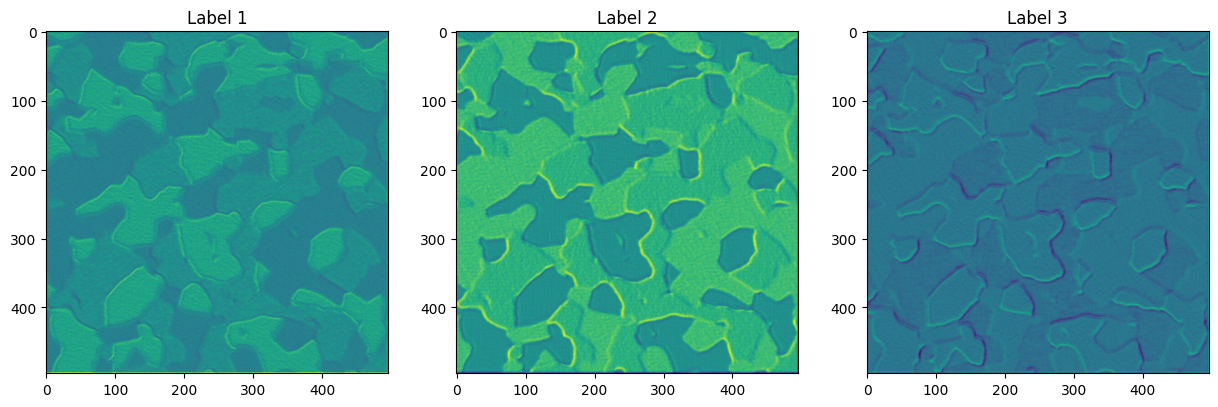

In [9]:
fig, axs = plt.subplots(1,3,figsize=(15,15))
axs[0].imshow(im_true[0,:,:].detach().numpy())
axs[0].set_title('Label 1')
axs[1].imshow(im_true[1,:,:].detach().numpy())
axs[1].set_title('Label 2')
axs[2].imshow(im_true[2,:,:].detach().numpy())
axs[2].set_title('Label 3')



In [13]:
im_true[2,:,:]

tensor([[0.3244, 0.3243, 0.3243,  ..., 0.3241, 0.3238, 0.3239],
        [0.3233, 0.3229, 0.3232,  ..., 0.3229, 0.3226, 0.3234],
        [0.3231, 0.3226, 0.3229,  ..., 0.3226, 0.3224, 0.3233],
        ...,
        [0.3230, 0.3224, 0.3226,  ..., 0.3225, 0.3222, 0.3233],
        [0.3229, 0.3228, 0.3230,  ..., 0.3229, 0.3229, 0.3237],
        [0.3228, 0.3224, 0.3224,  ..., 0.3227, 0.3225, 0.3232]],
       grad_fn=<SliceBackward0>)